In [26]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split

import numpy as np
#import pandas as pd

%matplotlib inline

In [2]:
rand_methods = ["uniform", "triangular", "betavariate", "expovariate", "gammavariate", "gauss", 
                "lognormvariate", "normalvariate", "vonmisesvariate", "paretovariate", "weibullvariate" ]

In [3]:
# Definition of parameter creation

class Neuron(object):
    def __init__(self, a, b, sat):
        self.a = a
        self.b = b
        self.saturation = sat

#creating the parameters is a tricky thing, the tuning curves must intersect the values for x=0 and x=1
#in a place that represents some interesting value, for this there are several restrictions

#the tuning curve must intersect the x axis between 0 and 1
#the tuning curve must intersect the y axis for x=0 between 0 and 1
#the tuning curve must intersect the y axis for x=1 between 0 and 1
#To do this the condition is:
# min_y + |b| <= a <= max_y for b that is negative
# min_y <= |b| <= max_y for b that is positive
# a <= -|max_y| for b that is positive
#also the actual y intersection for x=0 and x=1 can be truncated with a discontinuity

#add some other things like the minimum area under the curve that gets covered
#max_y_value === saturation point    
    
def param_creation(min_y_value=0.5, max_y_value=1.5, max_x_value=-1, saturation=None):
    if(saturation is None):
        saturation = random.uniform(0.8,1.0)
    s = random.choice([-1, 1])
    a=b=0
    if (s<0): # TODO show the derivation of this (is easy anyways)
        b = -random.uniform(0,1)
        a = random.uniform(min_y_value - b, max_y_value)
    else:
        a = -random.random()-max_x_value
        b = random.uniform(min_y_value, max_y_value)
    return Neuron(a,b,saturation)

#

In [4]:

def neuron_creation(min_y=0.5, max_y=1.5, min_x=-1.0, max_x=1.0, saturation=None):
    """
    This model creates two points, one in x range, one in y range, then decides if a >0 or a<0.
    Depending on the sign (which will be the sign of a), will resolve the linear equation to find 
    a and b
    """
    if(saturation is None):
        saturation = random.uniform(0.8,1.0)
    s = random.choice([-1, 1])
    a=b=0
    #the first point is for y=0 
    x1 = random.uniform(-1,1)
    y1 = 0
    #the second point is for x=+-1 
    x2 = s
    y2 = random.uniform(min_y,max_y)
    
    a = (y1-y2)/(x1-x2)
    b = y1 - a*x1
    
    return Neuron(a,b,saturation)


In [71]:
# Definition of function evaluation

def limited_neuron_evaluator(x, neuron ):
    a = neuron.a
    b = neuron.b
    sat=neuron.saturation
    return max(0, min(a*x + b, sat))
    

def neuron_evaluator(x, neuron ):
    a = neuron.a
    b = neuron.b
    sat = neuron.saturation
    return max(0, a*x + b)


In [106]:
class Ensemble(object):
    def __init__(self, n_neurons, min_y=0.5, max_y=1.5, max_x=1,min_x=-1,saturation=None):
        self.neurons = [neuron_creation(min_y, max_y, max_x, saturation) for i in range(n_neurons)]
    
    def encode_saturation(self, inputs):
        """
        For every point in the input will calculate all the outputs for all the neurons
        """
        output = []
        for x in inputs:
            outpoint = []
            for n in self.neurons:
                v = limited_neuron_evaluator(x, n)
                outpoint.append(v)
            output.append(outpoint)
        return output
    
    def encode(self, inputs):
        """
        For every point in the input will calculate all the outputs for all the neurons
        """
        output = []
        for x in inputs:
            outpoint = []
            for n in self.neurons:
                v = neuron_evaluator(x, n)
                outpoint.append(v)
            output.append(outpoint)
        return output

In [107]:
param_creation()

In [108]:
limited_neuron_evaluator(2, param_creation())

0.8137895858559088

In [109]:
xes  = np.linspace(start=-1.05, stop=1.05, num=100)

In [110]:
len(xes)

100

In [113]:
curves = []

for i in range(20):
    neuron = neuron_creation(max_y=1.0)
    points = [neuron_evaluator(x,neuron) for x in xes]
    curves.append((xes,points, neuron))

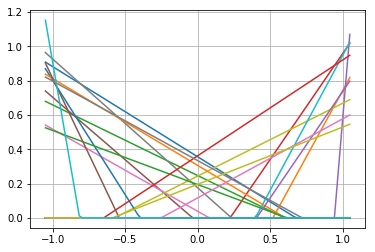

In [114]:
for c in curves:
    x,y,n = c
    plt.plot(x,y,label="%.2f x + %.2f"%(n.a, n.b))

plt.grid()
#plt.legend()

In [115]:
curves = []

for i in range(50):
    neuron = neuron_creation()
    points = [limited_neuron_evaluator(x,neuron) for x in xes]
    curves.append((xes,points, neuron))

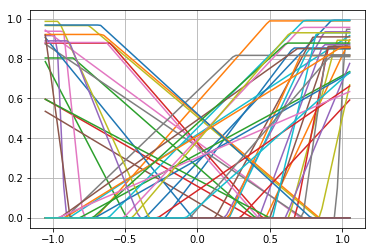

In [116]:
for c in curves:
    x,y,n = c
    plt.plot(x,y,label="%.2f x + %.2f"%(n.a, n.b))

plt.grid()
#plt.legend()

In [117]:
[i for i in range(2,20,2)]

[2, 4, 6, 8, 10, 12, 14, 16, 18]

In [118]:
Ensemble(10)

In [119]:
#Now I'll try with a few ensembles, an ensemble is a group of neurons.
#The encoded value will be ploted

ensembles = []
#make 20 different ensembles, each with 10 neurons
for i in range(10, 201, 10):
    ensembles.append(Ensemble(i))


In [164]:
%%time
#function to represent
x = np.linspace(0, 4*np.pi, 500)
#input currents to give to the neural ensemble
y = np.sin(x)
results_sat = [e.encode_saturation(y) for e in ensembles]
results_nosat = [e.encode(y) for e in ensembles]


CPU times: user 1.18 s, sys: 0 ns, total: 1.18 s
Wall time: 1.17 s


In [172]:
#to find out the needed decoder will have to get some points and then do the linear regression model
#for the output should be a linear combination of the encoded values

Xr1 = results_sat[-1]

X_train, X_test, y_train, y_test = train_test_split(Xr1, y, test_size=0.33)

In [173]:
lm = linear_model.LinearRegression()
model = lm.fit(Xr1,y)

In [199]:
xt = np.linspace(0, 8*np.pi, 1000)
yt = np.sin(xt)

In [200]:
nr = ensembles[-1].encode_saturation(yt)

In [201]:
pred = model.predict(nr)

In [209]:
model.score(X_test, y_test)

0.99999999997478672

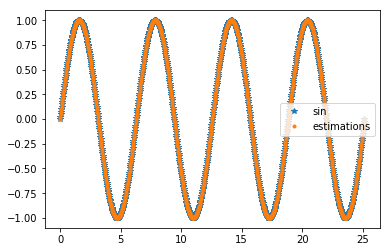

In [202]:
plt.plot(xt, yt, "*", label="sin")
plt.plot(xt, pred, ".", label="estimations")
plt.legend()

In [203]:
#it seems that the linear regression doesn work quite well, 
#I'll have to derivate it by hand and write down the equations
#and then evaluate if it is correct or not ... AGAIN!

#it seems that the error I had seen was due to some problem with the things that I was encoding! ...
# ... do more research about it until I understand it and can reproduce the results!
#The issue is that I was encoding the linear function instead of the y values of the 

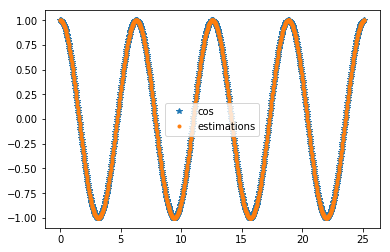

In [204]:
cxt = np.linspace(0, 8*np.pi, 1000)
cyt = np.cos(cxt)
cnr = ensembles[-1].encode_saturation(cyt)
cpred = model.predict(cnr)

plt.plot(cxt, cyt, "*", label="cos")
plt.plot(cxt, cpred, ".", label="estimations")
plt.legend()

In [128]:
#I'll graph anyways the encoded responses(each neuron point) for the input function

In [129]:
enc_10_s = np.array(results_sat[0])
enc_50_s = np.array(results_sat[4])
enc_10_ns = np.array(results_nosat[0])
enc_50_ns = np.array(results_nosat[4])

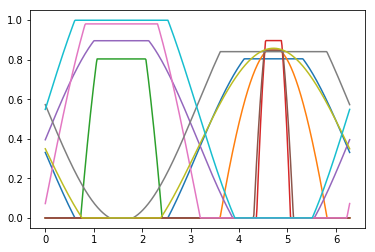

In [130]:
plt.plot(x,enc_10_s);

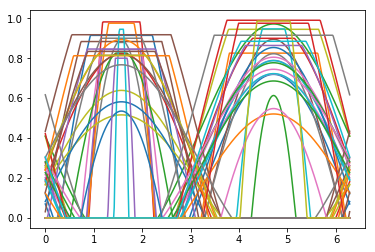

In [131]:
plt.plot(x, enc_50_s);

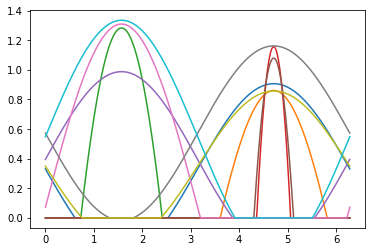

In [132]:
plt.plot(x, enc_10_ns);

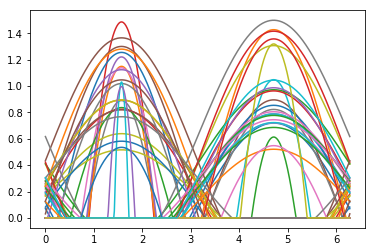

In [133]:
plt.plot(x, enc_50_ns);

In [134]:
#checking these results, we clearly see that there is a nice encoding that shows a rectified sine/cosine wave.

#The issue with saturation can be dealt with either:
# - increasing the saturation limit (anyways I do believe that saturation is needed)
# - taking out the saturation (evaluation without saturation)
# - normalizing the input to have smaller values

# The NICE thing about saturation is that it includes a really strong 
#    non-linearity that ?might? allow for interesting behaviours

#Crazy idea: Maybe saturation can be used ALSO as a kind of SIGNALING to other modules/parts



In [207]:
#Now will be a nice place to try decoding different
# functions (quadriatics, etc, oscilators, memory and some more ...

In [205]:
#Now I need to be able to instead of representing single scalars, be able to represent VECTORS -> another notebook

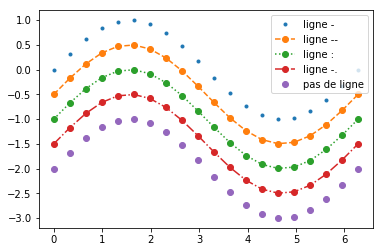

In [18]:
plt.plot(x, y, ".", label="ligne -")
plt.plot(x, y-0.5, "o--", label="ligne --")
plt.plot(x, y-1, "o:", label="ligne :")
plt.plot(x, y-1.5, "o-.", label="ligne -.")
plt.plot(x, y-2, "o", label="pas de ligne")
plt.legend()

plt.show()